In [1]:
#run me first!
#click here and press ctrl-enter

from public.desyncedcompiler import *
from astrender import astrender
from asthelpers import *
import json
import ast

# Introduction to Python to Desynced Compiler 

In this project, we aim to develop a Python to Desynced compiler. Desynced is a video game that comes with its own visual programming language:  
https://www.desyncedgame.com/  
The goal for this project was for me to learn how to compile from an Abstract Syntax Tree.  I hope you find it useful for either playing Desynced or for writing your own compilers!  This was my first ever compiler, so feedback is warmly welcomed!

# Using this Workbook
Each step is divided in two parts - the code to accomplish the step, and a separate block to demonstrate it.  Be sure to execute all cells above the step you're interested in, and modify experimental code cell to see how the associated transform works.

## Steps Involved  
### 1. Generate an Abstract Syntax Tree (AST) from Python
### 2. Replace +-*/ with Function calls Add, Subtract, etc.
### 3.  Translate function calls to a generic "Desynced Call"   
### 4. Flatten Nested Calls 
### 5. Label Variables and Frames
### 6. Flow Control
### 7. Import Desynced Ops and Information from Data Dump  
### 8. Translate to a Desynced Object (DSO)
### 9. Package the DSO in Base62 Format
### 10. Profit!

# Suggested Code to Test With
Try these code segments to stress various parts of the compilation process:

```python
# Simple Assignment:
P1 = 10
P2 = "metalore", 20

# Test deeply nested math:
A = B + C + D + E + F

# Test Order of Operations:
A = B*C + D*E

# Difficult Flow Statement:
if CompareNumber(GetDistance(P1), 3):
    P2 += A-1

# Deeply nested function calls:
f(g(h(i(j()))))
```
It can be helpful to use examples that stress the subsystem you're interested in, even if it won't pass later steps.


In [2]:
def ExampleCode(P1):
    P3=0
    for P1 in LoopEntitiesRange(1, "v_own_faction"):
        if Match(P1, "v_is_foundation"):
            pass
        else:
            P3+=1
    if CompareNumber(P3,3):
        pass
    else:
        P2 = SetNumber(P1, 10)
        MoveAwayRange(P2)
        

python_to_desynced(ExampleCode)

instructions initialized
Initializing Mini Racer


'DSCAa2ck5yi0tMgiz1MRX0a0bVz1V1eGTcc1c2Og80pYjYp42IPou18TAns1eeGdl1alwnM2zAp5Q29zps62r3E3v1BPFPb2MS1SC3kPoxt2livpZ2EOR2a0M9p6L4GjMUe1ZLNBq1qypVy31mbqu2hFKze3vQonM3Rwtib1U4zsv2tAqSM4G3tvj2iwAVZ3pdTL834Tpno1uuPVM4PCHFh0ImrYg42HFK34UuBhM2Z0nk74Hw5z03XeSRU4ALsIz2YxIG53hDsCc3Ugz3P2RMPin3TH4YD1ecjnb4P3wKP4aSXfz2dvCt03Qathz1hHNuU4RkIx12hk3td28rFPM0l91Ux'

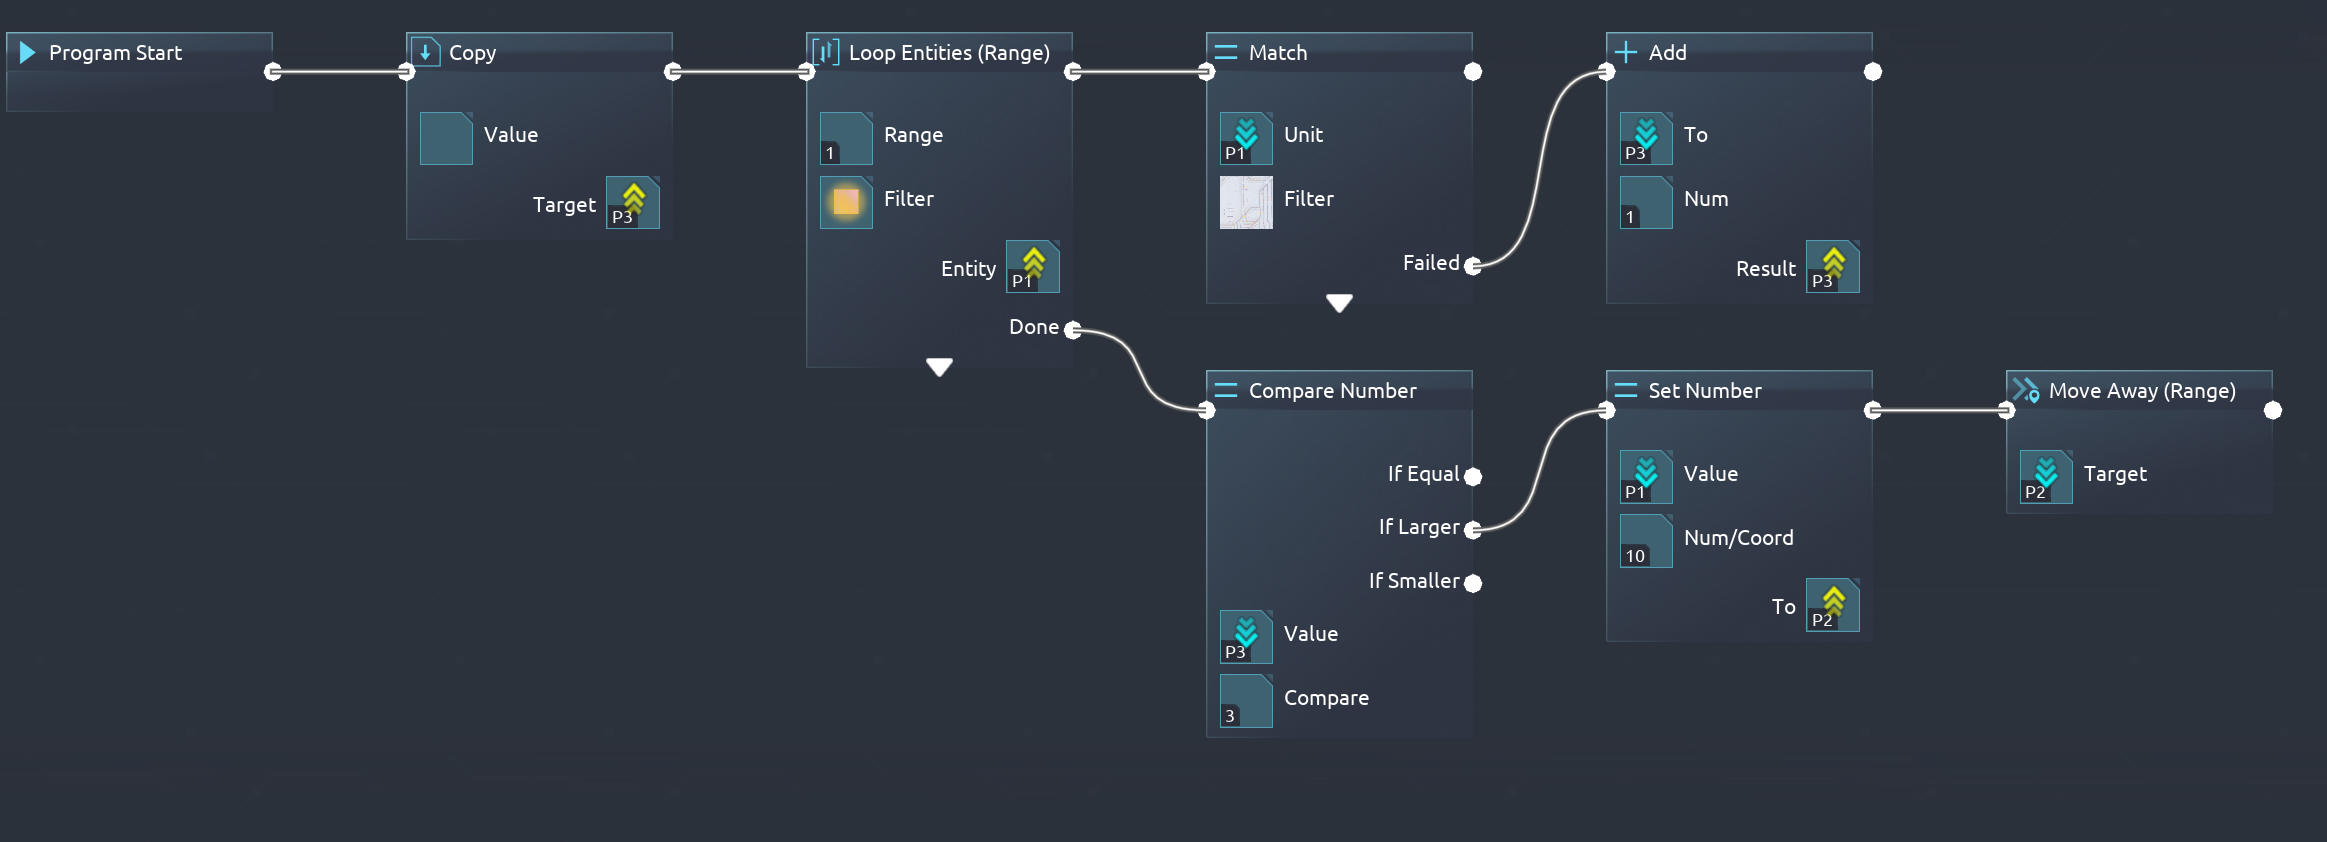

## 1. Generate an Abstract Syntax Tree (AST)

The Abstract Syntax Tree (AST) is one of the steps in the usual (python) compilation process.  
Starting with the AST let's us skip tokenizing (lexing), syntax analysis (parsing), and some aspects of semantic analysis (rules checking), and start immediately with a structure we can analyze and manipulate programmatically.

Feel free to try AST parsing any python code you'd like - either define a function and reference it (example 1) or put it in a string and pass it directly (example 2).  
It is worth spending some time getting comfortable at this step.

If this step fails, check that you ran the very first cell in the notebook first!

AST Tree from inspected source:
Module(
    body=[
        FunctionDef(
            name='DesyncedCode',
            args=arguments(
                posonlyargs=[],
                args=[arg(arg='P2', annotation=None)],
                vararg=None,
                kwonlyargs=[],
                kw_defaults=[],
                kwarg=None,
                defaults=[],
            ),
            body=[
                For(
                    target=Name(id='A', ctx=Store()),
                    iter=Call(
                        func=Name(id='LoopSignalMatch', ctx=Load()),
                        args=[Name(id='P2', ctx=Load())],
                    ),
                    body=[
                        Assign(
                            targets=[Name(id='P3', ctx=Store())],
                            value=Call(
                                func=Name(id='SelectNearest', ctx=Load()),
                                args=[
                                    Name(id='A', ctx=Load()),


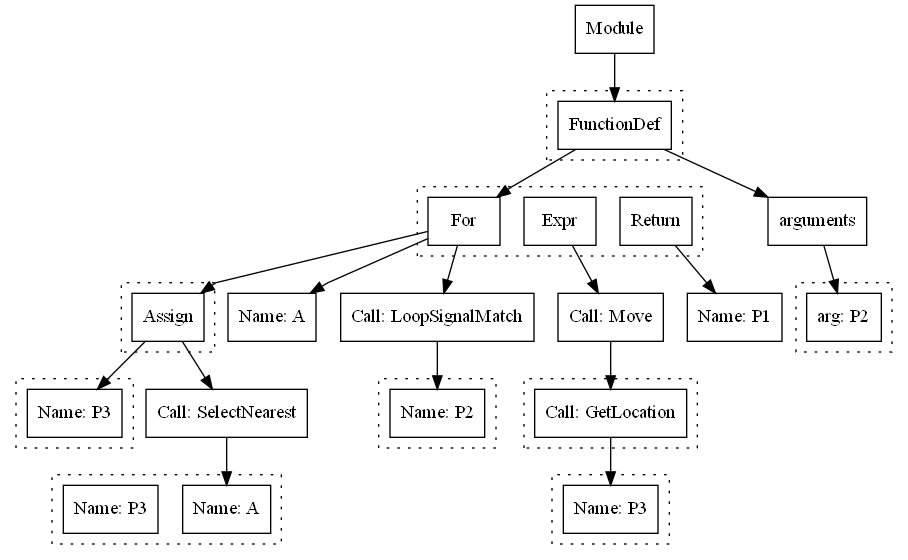

In [3]:
def DesyncedCode(P2):
    for A in LoopSignalMatch(P2):
        P3 = SelectNearest(A, P3)
    Move(GetLocation(P3))
    return P1

source_code = inspect.getsource(DesyncedCode)
tree = ast.parse(source_code, type_comments=False)
print("AST Tree from inspected source:")
astprint(tree)
astrender(tree)



AST Tree from string source:
Module(
    body=[
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=BinOp(
                        left=Name(id='B', ctx=Load()),
                        op=Add(),
                        right=Name(id='C', ctx=Load()),
                    ),
                    op=Add(),
                    right=Name(id='D', ctx=Load()),
                ),
                op=Add(),
                right=Constant(value=3, kind=None),
            ),
        ),
    ],
)


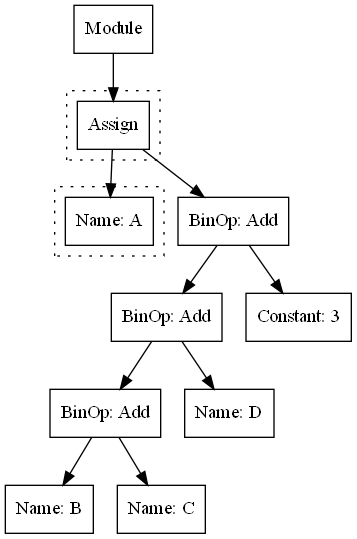

A = B + C + D + 3


In [4]:
source_code_by_string="""
A=B+C+D+3
"""
tree = ast.parse(source_code_by_string, type_comments=False)
print("\n\nAST Tree from string source:")
astprint(tree)
g = astrender(tree)
print(unparse(tree))

## 2. Replace +-*/ with Function calls Add, Subtract, etc.

Python supports so many different ways to express things, this step narrows that down a bit.  
BinOps like A+B get replaced with Calls like Add(A,B).  
This is done early so that all function calls in the AST use the same syntax, which makes the rest of the code easier.

The BinOpReplacementVisitor is a NodeTransformer - it walks the AST and calls visit_BinOp on any BinOp nodes, and visit_AugAssign on any AugAssign nodes.  Those nodes are replaced by whatever is returned from those calls.

Try experimenting with order of operations and see if the resulting tree makes sense.

In [5]:
# %load -s replace_binops_with_functions ./public/desyncedcompiler.py
def replace_binops_with_functions(tree):
    class BinOpReplacementVisitor(ast.NodeTransformer):
        # Replace binary operations with function calls
        binop_map = {ast.Add: 'Add',
                     ast.Sub: 'Subtract',
                     ast.Mult:'Multiply',
                     ast.Div: 'Divide',
                     ast.Mod: 'Modulo',
                        }
        def visit_BinOp(self, node):
            if isinstance(node.op, ast.operator) and node.op.__class__ in self.binop_map:
                #self.generic_visit(node)
                new_node = ast.Call(
                    func=ast.Name(id=self.binop_map[type(node.op)], ctx=ast.Load()),
                    args=[node.left, node.right],
                    keywords=[],
                    starargs=None,
                    kwargs=None
                )
                new_node=self.visit(new_node)
                return new_node
            else:
                return node

        def visit_AugAssign(self, node):
            if isinstance(node.op, ast.operator) and node.op.__class__ in self.binop_map:
                new_node = ast.Assign(
                    targets = [node.target],
                    value = ast.Call(
                        func=ast.Name(id=self.binop_map[type(node.op)], ctx=ast.Load()),
                        args=[node.target, node.value],
                        keywords=[],
                        starargs=None,
                        kwargs=None
                    )
                )
                
                new_node=self.visit(new_node)
                return new_node
            else:
                return node

    visitor=BinOpReplacementVisitor()
    return visitor.visit(tree)

# Section 3: Flatten Nested Calls


In [6]:
source_code='''
A=A+B                        # Typical Binary Operation
A+=B                         # Augmented Assignment
A=B*C+D/E-F                  # Test order of operations
A=DummyFunction(C,D+1+3)     # Test inside of Func Args
'''

tree = ast.parse(source_code, type_comments=False)
print("AST Tree before processing:")
#astprint(tree)
print()
print("ASTree after replacing binary ops")
tree = replace_binops_with_functions(tree)
astprint(tree)
print()
print("Unparsed back to Python Code")
print(unparse(tree))

AST Tree before processing:

ASTree after replacing binary ops
Module(
    body=[
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=Call(
                func=Name(id='Add', ctx=Load()),
                args=[
                    Name(id='A', ctx=Load()),
                    Name(id='B', ctx=Load()),
                ],
            ),
        ),
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=Call(
                func=Name(id='Add', ctx=Load()),
                args=[
                    Name(id='A', ctx=Store()),
                    Name(id='B', ctx=Load()),
                ],
            ),
        ),
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=Call(
                func=Name(id='Subtract', ctx=Load()),
                args=[
                    Call(
                        func=Name(id='Add', ctx=Load()),
                        args=[
                            Call(
       

# 3. Flatten Nested Calls 
Desynced's execution environment can only handle variables and constants as arguments to a function:  f(g(x)) is outside it's capabilities.  
This step flattens code using temporary variables:  
```python  
A = Distance(GetClosestEntity("Enemy"))
   -->
temp1 = GetClosestEntity("Enemy")
A     = Distance(temp1)
```

In [7]:
# %load -s flatten_calls ./public/desyncedcompiler.py
def flatten_calls(tree):
    class FlatteningTransformer(ast.NodeTransformer):
        def __init__(self):
            super().__init__()
            self.temp_count = 1

        def visit_UnaryOp(self, node):
            if isinstance(node.op, ast.Not):
                operand = node.operand
                operand.func.id = operand.func.id+'__NOT'
                return self.visit(operand)

        def visit_Call(self, node):
            nodelist = []
            for i, arg in enumerate(node.args):
                if isinstance(arg, ast.Call):                
                    temp_var = f'Temp_{self.temp_count}'
                    self.temp_count += 1
                    node.args[i] = ast.Name(id=temp_var, ctx=ast.Load())
                    #list of all calls that have to happen first
                    ncalls = self.visit_Call(arg)
                    ncalls[-1].targets=[ast.Name(id=temp_var, ctx=ast.Store())]
                    nodelist.extend(ncalls)
            assign_wrapper = ast.Assign(targets=[], #to be filled in by parent
                                        value=node,
                                        keywords=[])
            nodelist.append(assign_wrapper)
            
            return nodelist


        def visit_Assign(self, node):
            if isinstance(node.value, (ast.Name, ast.Constant, ast.Tuple)):
                # Special case for a bare Assignment - this is a Copy function, which is 'set_reg' internally
                call = ast.Call(func = ast.Name(id='Copy', ctx='Load'),
                                targets = node.targets,
                                args = [node.value],
                                keywords=[])
                node.value = call
                return node
            if isinstance(node.value, ast.Call):
                ncalls = self.visit(node.value)
                ncalls[-1].targets=node.targets
                return ncalls

        def visit_Expr(self, node):
            if isinstance(node.value, ast.Call):
                ncalls = self.visit(node.value)
                #ncalls[-1] = ast.Expr(value = ncalls[-1].value)
                return ncalls


    class WhilePatcher(ast.NodeTransformer):
        '''
        Desynced doesn't natively support "while" behavior.  
        Specifically, only "Loop" instructions capture flow exit, but we want flow capture
        coupled to generic conditional statements.  This patches in a dummy run-once loop:

        while conditional:
            body
            
        is translated to

        ::loop_start::
        if conditional:
            while once:
                body
            goto ::loop_start::

        The "goto" is added during flow control.
        '''
        def visit_While(self, node):
            node.body.insert(0, ast.Call(
                func=ast.Name(id='LoopRecipeIngredients', ctx=ast.Load()),
                args=[ast.Constant(value='metalplate')]
                ))
            for i in range(1, len(node.body)):
                node.body[i] = self.visit(node.body[i])
            return node
            
    #whilepatch = WhilePatcher()
    #tree = whilepatch.visit(tree)

    transformer = FlatteningTransformer()
    tree = transformer.visit(tree)
    return tree

# Section 4: Translate to DS Calls


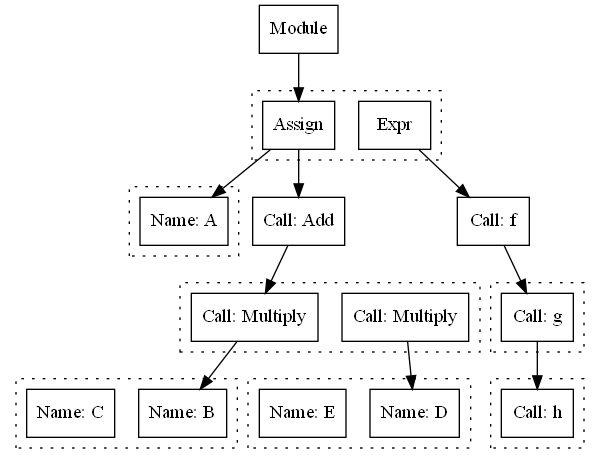

In [8]:
source_code='''
# Test nested math
A = B*C+D*E
f(g(h()))
'''


tree = ast.parse(source_code, type_comments=False)
tree = replace_binops_with_functions(tree)
astrender(tree)

tree = flatten_calls(tree)

#print("Unparsed after Transforms:")
#print(unparse(tree))
print()
#astrender(tree)
#astprint(tree)

# 4.  Translate function calls to a generic "Desynced Call"   
Defining a custom AST node type allows us to decorate it with additional information that will later be useful for compilation.  
Specifically, each DS Function containsan *opcode*, *inputs*, *outputs*, and *execution flows*.  
Python's AST includes the inputs as part of the call node, but outputs are held in an Assign node and execution flow is handled fundamentally different.  

In [9]:
# %load -s DS_Call,convert_to_ds_call  ./public/desyncedcompiler.py
class DS_Call(ast.Assign):
    _fields = ('targets', 'args', 'op', 'frame', 'next')

    def __init__(self, targets, args, op):
        self.targets = targets
        self.args = args
        self.next = {}
        self.frame = -1
        self.op = op

    def unparse(self, node):
        self.fill()
        self.traverse(node.targets)
        if(len(node.targets)): self.write(' = ')
        self.write(f"DS_Call_{node.op}")
        with self.delimit("(", ")"):
            comma = False
            for e in node.args:
                if comma:
                    self.write(", ")
                else:
                    comma = True
                self.traverse(e)
        self.write(f" | {node.frame}-->{node.next}")

def convert_to_ds_call(tree):
    
    class DS_Call_Transformer(ast.NodeTransformer):   
        
        def visit_Call(self, node, target=None):
            if target:
                node.targets=[target]
            return [DS_Call( targets=[target], args=node.args, op=node.func.id)]

        def visit_Assign(self, node):
            if isinstance(node.value, (ast.Name, ast.Constant, ast.Tuple)):
                # Special case for a bare Assignment - this is a Copy function, which is 'set_reg' internally
                new_node = DS_Call(targets = node.targets, args = [node.value], op = 'Copy')
                new_node = self.visit(new_node)
                return new_node
            nodelist = self.visit_Call(node.value)
            nodelist[-1].targets = node.targets
            for n in nodelist:
                self.visit(n)
            return nodelist

        def visit_Expr(self, node):
            nodelist = self.visit_Call(node.value)
            for n in nodelist:
                self.visit(n)
            return nodelist

        def visit_Tuple(self, node):
            if isinstance(node.elts[0], ast.Name):
                return [e for e in node.elts]
            if isinstance(node.elts[0], ast.Constant):
                return ast.Constant( value=[e.value for e in node.elts])
            return node


    return DS_Call_Transformer().visit(tree)

# Section 5: Labeling Pass


In [10]:
''' Monkey-Patch in an unparser for DS Calls '''
ast._Unparser.visit_DS_Call = DS_Call.unparse

Module(body=[])



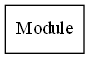

In [11]:
source_code='''

'''

tree = ast.parse(source_code, type_comments=False)
tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)

astprint(tree)
print(unparse(tree))
astrender(tree)

# 5. Label Variables and Frames

Temporary variables are renamed.  
All DS_Calls are assigned a frame number, which is the desynced equivalent of a line number.

This is accomplished by first enumerating all of the known variables in the code (VariableFinder).  Then find the lowest unused local variable, and remap temporary variables starting there.  I don't do any form of variable lifespan checking - This is inefficient but usable.  

Then we use another NodeTransformer to visit every DS_Call and give it a frame id number.  Fortunately the NodeTransformer walks the tree in a reasonable manner, which makes it easier to visually inspect later.  This could work with pseudorandom assignment, but this way is cleaner.


In [12]:
# %load -s label_frames_vars ./public/desyncedcompiler.py
def label_frames_vars(tree, debug=False):
    allowed_names = 'ABCDEFGHIJKLMNOQRSTUVWXYZ' #don't allow P
    
    class ParameterFinder(ast.NodeVisitor):
        def __init__(self, variables={}):
            self.variables = variables

        def visit_arguments(self, node):
            '''
            Named arguments (P1, P2, P3, ...) always use their named slot.
            Unnamed arguments are given the next available slot.
            This may leave gaps.
            '''
            p_ix = 1
            for arg in node.args:
                if arg.arg[0] == "P" and arg.arg[1:].isdigit():
                    new_ix = int(arg.arg[1:])
                    if new_ix > p_ix: 
                        p_ix = new_ix
                    elif new_ix < p_ix:
                        raise SyntaxErrorFromAST(
                            f'A named Parameter ({arg.arg}) with a lower index was given after a higher index ({p_ix})',
                            arg)
                self.variables[arg.arg] = f"P{p_ix}"
                p_ix+=1

    class VariableFinder(ast.NodeVisitor):
        def __init__(self, variables={}):
            self.variables = variables

        def visit_Name(self, node):
            if node.id not in self.variables.values():
                if node.id in allowed_names:
                    self.variables.setdefault(node.id,node.id)
                else:
                    self.variables.setdefault(node.id,None)

    
    def remap_temp_variables(mapping):
        '''
        At this point parameters are already renamed
        '''
        existing_keys = list(mapping.keys())
        for key in existing_keys:
            if mapping[key] is None:
                name = next((name for name in allowed_names if name not in mapping.values()))
                mapping[key] = name
        return mapping 

    
    class VariableLabeler(ast.NodeTransformer):
        def __init__(self, mapper):
            super().__init__()
            self.mapper = mapper
        
        def visit_Name(self, node):
            if node.id in self.mapper.keys():
                    node.id = self.mapper[node.id]
            return node

        def visit_arg(self, node):
            if node.arg in self.mapper.keys():
                node.arg = self.mapper[node.arg]+'|'+node.arg
            return node
            
    class FrameLabeler(ast.NodeTransformer):  
        def __init__(self):
            super().__init__()
            self.frame_count = 0
            
        def visit_DS_Call(self, node):
            node.frame = self.frame_count
            self.frame_count+=1
            return node

    parameterfinder = ParameterFinder()
    parameterfinder.visit(tree)
    parameters = parameterfinder.variables
    if (debug): 
        print(parameters)
        
    variablefinder = VariableFinder(parameters)
    variablefinder.visit(tree)
    parameters_and_variables = variablefinder.variables
    if (debug): 
        print(parameters_and_variables)
        
    remap = remap_temp_variables(parameters_and_variables)
    flipped_remap = {k:v for k,v in remap.items()}
    if (debug): 
        print(f'{flipped_remap=}')
        
    varlabeler = VariableLabeler(flipped_remap)
    tree = varlabeler.visit(tree)
    
    framelabeler = FrameLabeler()
    tree = framelabeler.visit(tree)
    return tree

# Section 6: Flow Control


{'named_parameter': 'P1', 'P2': 'P2', 'P6': 'P6', 'second_named_parameter': 'P7'}
{'named_parameter': 'P1', 'P2': 'P2', 'P6': 'P6', 'second_named_parameter': 'P7', 'Temp_1': None, 'A': 'A', 'named_variable': None, 'B': 'B', 'Temp_3': None, 'C': 'C', 'Temp_2': None, 'D': 'D', 'E': 'E'}
flipped_remap={'named_parameter': 'P1', 'P2': 'P2', 'P6': 'P6', 'second_named_parameter': 'P7', 'Temp_1': 'F', 'A': 'A', 'named_variable': 'G', 'B': 'B', 'Temp_3': 'H', 'C': 'C', 'Temp_2': 'I', 'D': 'D', 'E': 'E'}


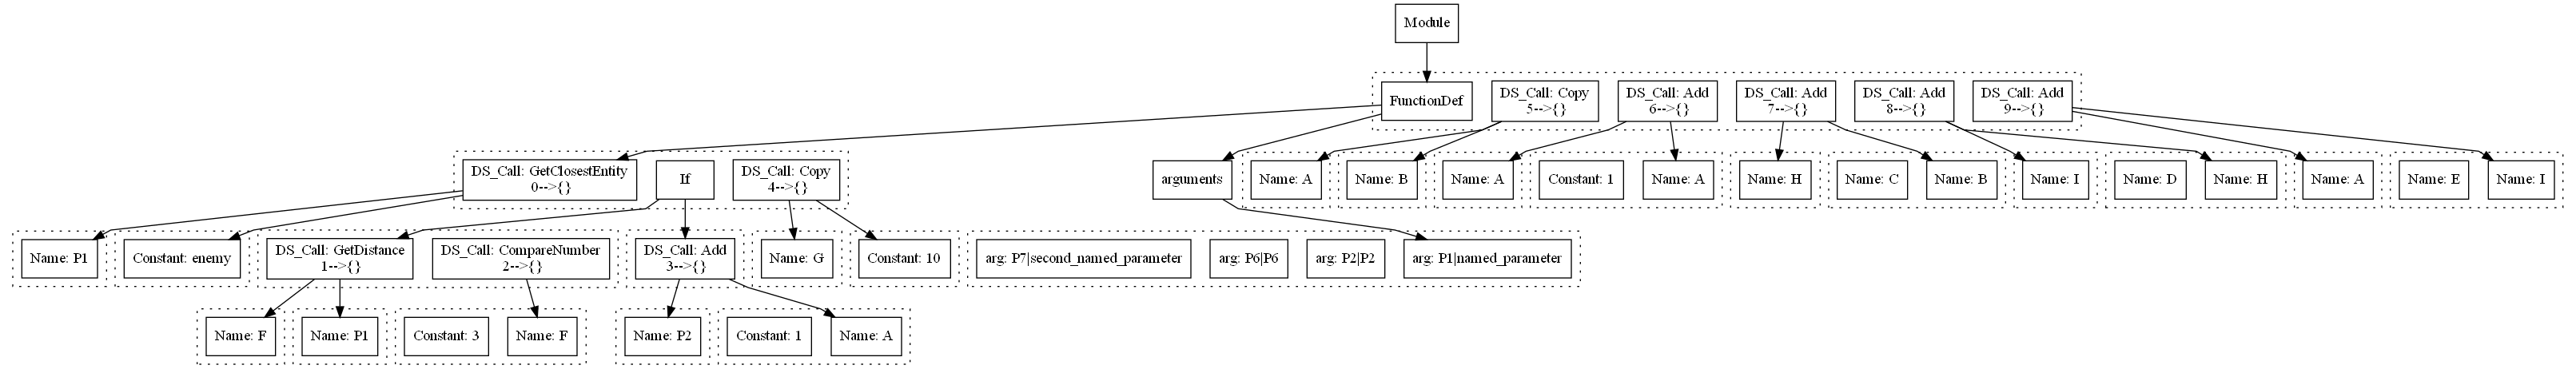

def LabelerTest(P1|named_parameter, P2|P2, P6|P6, P7|second_named_parameter):
    P1 = DS_Call_GetClosestEntity('enemy') | 0-->{}
    if 
    F = DS_Call_GetDistance(P1) | 1-->{}
    DS_Call_CompareNumber(F, 3) | 2-->{}:
        P2 = DS_Call_Add(A, 1) | 3-->{}
    G = DS_Call_Copy(10) | 4-->{}
A = DS_Call_Copy(B) | 5-->{}
A = DS_Call_Add(A, 1) | 6-->{}
H = DS_Call_Add(B, C) | 7-->{}
I = DS_Call_Add(H, D) | 8-->{}
A = DS_Call_Add(I, E) | 9-->{}


In [13]:
source_code='''
def LabelerTest(named_parameter, P2, P6, second_named_parameter):
    P1 = GetClosestEntity("enemy")
    if CompareNumber(GetDistance(P1), 3):
        P2 = A+1
    named_variable = 10

A=B
A=A+1
A = B+C+D+E

'''


tree = ast.parse(source_code)#, type_comments=False)
#astrender(tree)

tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)
tree = label_frames_vars(tree, debug=True)
astrender(tree)
print(unparse(tree))

In [14]:
def RadarTower(enemy, broken, dropped, construction):
  P1 = GetClosestEntity("v_enemy")
  if CompareNumber(Distance(enemy), 0):
    B=1
  else:
    C=2


tree = ast.parse(inspect.getsource(RadarTower), type_comments=False)

tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)

tree = label_frames_vars(tree, debug=True)


{'enemy': 'P1', 'broken': 'P2', 'dropped': 'P3', 'construction': 'P4'}
{'enemy': 'P1', 'broken': 'P2', 'dropped': 'P3', 'construction': 'P4', 'Temp_1': None, 'B': 'B', 'C': 'C'}
flipped_remap={'enemy': 'P1', 'broken': 'P2', 'dropped': 'P3', 'construction': 'P4', 'Temp_1': 'A', 'B': 'B', 'C': 'C'}


# 6. Flow Control

Flow control dictates the order in which these ops are called.  The linear sections are easy - just link each frame to the next one.
The first and last frame in a sequence are special.  The first frame is where other sequences link into a sequence, the last frame is where it links out.  
The helper function makes it easier to identify these special frames, and then each of the flow control elements (IF, While, For) have to be special cased.

I don't use a Transformer class here so that I have better access to the parents of a node that is being visited.

In [15]:
# %load -s flow_control ./public/desyncedcompiler.py
def flow_control(tree):

    def find_first_last_DS_Call(list):
        class DSFinder(ast.NodeVisitor):
            def __init__(self):
                self.last=None
                self.first= None
    
            def visit_DS_Call(self, node):
    
                self.last = node
                if self.first is None:
                    self.first = node
    
        finder = DSFinder()
        for tree in list:
            finder.visit(tree)
        return finder.first, finder.last
    
    def flow_list(nodelist, exit=-1):
        #myexit = find_first_last_DS_Call(nodelist)
        for item, next_item in zip(nodelist, nodelist[1:] + [None]):
            lexit = exit if next_item is None else find_first_last_DS_Call([next_item])[0].frame
            if isinstance(item, DS_Call):
                item.next = {'next': lexit}
            if isinstance(item, ast.While):
                flow_While(item, lexit)
            if isinstance(item, ast.If):
                flow_If(item, lexit)
            if isinstance(item, ast.For):
                flow_For(item, lexit)
    
    def flow_While(node, exit=-1):
        flow_list(node.test)
        flow_list(node.body)
        body_first, body_last = find_first_last_DS_Call(node.body)
        test_first, test_last = find_first_last_DS_Call(node.test)
    
        test_last.next = {'next': body_first.frame, 'exit': exit}
        body_first.next['exit'] = test_first.frame
    
    def flow_If(node, exit=-1):
        flow_list(node.test)
        flow_list(node.body)
        flow_list(node.orelse)
        body_first, body_last = find_first_last_DS_Call(node.body)
        test_first, test_last = find_first_last_DS_Call(node.test)
        orelse_first, orelse_last = find_first_last_DS_Call(node.orelse)
    
        test_last.next = {'next': exit if body_first is None else body_first.frame,
                          'else': exit if orelse_first is None else orelse_first.frame}
        if body_last:
            body_last.next = {'next': exit}
        if orelse_last:
            orelse_last.next = {'next':exit}
    
    
    def flow_For(node, exit=-1):
        target = node.target
        ''' The unparser needs the for loop to still have a valid target '''
        node.target = ast.Name(id='_', ctx=ast.Store())

        flow_list(node.body)
        flow_list(node.iter)
        body_first, body_last = find_first_last_DS_Call(node.body)
        iter_first, iter_last = find_first_last_DS_Call(node.iter)
    
        iter_last.next = {'next': body_first.frame, 
                          'exit': exit}
        body_last.next= {'next': False}
        if isinstance(target, list):
            iter_last.targets = target
        else:
            iter_last.targets = [target]
            
    # this is a real bad hack and will need to be fixed to support nested function calls.
    if isinstance(tree.body[0], ast.FunctionDef):
        return flow_list(tree.body[0].body)
    return flow_list(tree.body)

# Section 7: Import Desynced Ops


In [16]:
source_code='''

while CheckBattery(GetSelf()):
    B=B+1
'''
'''
    A=1+2+3
for C in LoopSignalMatch(P3):
   P4=("Ore", 17)
'''
"""
for _, A in LoopSignalMatch("v_droppeditem"):
    P1 = SelectNearest(A, P1)
if CheckSpaceForItem(P1):
    PickUpItems(P1)
else:
    P2 = _
    for B in LoopSignalMatch("v_color_green"):
        P2 = SelectNearest(B, P2)
    DropOffItems(P2)
"""


tree = ast.parse(source_code, type_comments=False)

tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)
tree = label_frames_vars(tree)
#astprint(tree)
flow_control(tree)
#astprint(tree)
print(unparse(tree))
#astrender(tree)

while 
A = DS_Call_GetSelf() | 0-->{'next': 1}
DS_Call_CheckBattery(A) | 1-->{'next': 2, 'exit': -1}:
    B = DS_Call_Add(B, 1) | 2-->{'next': -1, 'exit': 0}


# 7. Import Desynced Ops and Information from Data Dump

Desynced  has its set of operations and functions and constant that it understands.  We need to parse these out of the game files in order to link correctly.  desyncedexport.json contains this export; I've been given permission by fine folk at Stage Games to include this export here.

You can export your own by using this mod: https://steamcommunity.com/sharedfiles/filedetails/?id=3174494666

If you play with mods that add instructions, or the core game has added new instructions since last updated, simply re-export and the compiler will support the new instructions.


In [17]:
# %load -s import_desynced_ops ./public/desyncedcompiler.py
def import_desynced_ops(path = None, jsonfile = None):
    def to_function_name(string):
        # Desynced block names are typically all capitalized.  Standardize on this.
        # Obsolete instructions are marked by being surrounded by asterixes.  Replace with _ so it is a valid python function name
        result =''.join([word.capitalize() for word in string.replace('*','_').replace('(','').replace(')','').split()])
        return result
    if path:
        with open (path, 'r') as jsonfile:
            import json
            raw_import = json.load(jsonfile)["instructions"]
    elif jsonfile:
        raw_import = jsonfile["instructions"]
    return {to_function_name(v['name']):{**v, 'op':k} for k,v in raw_import.items() if 'name' in v.keys()}

# Section 8: Translate to DSO


In [18]:
ds_ops = import_desynced_ops(path="./public/desyncedexport.json")

# 8. Translate to a Desynced Object (DSO)

The modified AST tree now has all the information necessary to emit actual op codes.  

Desynced's intermediate langauge visualizes as JSON, but it was not designed for readability.  All descriptive field names are stripped and replaced with numerical indices.  

At the end of this we have something that should be able to be converted by the tool on this webpage:
https://stagegames.github.io/DesyncedJavaScriptUtils/

Note that printing a python dict is slightly different than printing as json string.


In [19]:
# %load -s create_dso_from_ast ./public/desyncedcompiler.py
def create_dso_from_ast(tree, debug=False):
    ds_ops = desynced_ops.instructions()
    class DSO_from_DSCalls(ast.NodeVisitor):
        def __init__(self, debug=False):
            self.dso={}
            self.debug=debug
            self.parameters={}

        def translate_register_or_value(self, tlist, ix):
            try:
                val = tlist[ix]
            except IndexError:
                return False
            # Values get Handled here.
            #  '_" is special cased to mean not used.
            #  Local variables (A,B,C) are emitted as strings.
            #  Parameters (P1, P2) are emitted as numbers.
            if isinstance(val, ast.Name):
                if val.id == '_':
                    return False
                if val.id[0] == 'P':
                    parameter_ix = int(val.id[1:])
                    self.parameters.setdefault(parameter_ix,True)
                    return parameter_ix
                specialregs= {'Goto':-1,
                              'Store':-2,
                              'Visual':-3,
                              'Signal':-4}
                if val.id in specialregs.keys():
                    return specialregs[val.id]
                return val.id
                
            if isinstance(val, ast.Constant):
                if isinstance(val.value, int):
                    return {"num": val.value}
                if isinstance(val.value, str):
                    #this is where to add translation of constants, e.g. "Metal Ore" to "metalore"
                    return {"id": val.value}

                if isinstance(val.value, list):
                    if isinstance(val.value[0], int) and isinstance(val.value[1], int):
                        return {"coord": {"x": val.value[0], "y": val.value[1]} }
                    if isinstance(val.value[0], str) and isinstance(val.value[1], int):
                        return {"id": val.value[0], "num": val.value[1]}
                    if isinstance(val.value[0], int) and isinstance(val.value[1], str):
                        return {"id": val.value[1], "num": val.value[0]}

        def translate_exec(self, next, exec_ix):
            # This is just scaffolding at the moment
            # Needs a ton of work...
            try:
                return list(next.values())[exec_ix]+1
            except IndexError:
                return False

        def visit_DS_Call(self, node):
            op = ds_ops[node.op]
            res={}
            res['op'] = op['op']
            if node.next['next'] != node.frame+1:
                res['next'] = node.next['next']
            target_ix=0
            arg_ix=0
            exec_ix=1
            if 'args' in op.keys():
                if self.debug:
                    print(op['args'])
                for i, arg in enumerate(op['args']):
                    if arg[0] == 'out':
                        res[str(i)] = self.translate_register_or_value(node.targets,target_ix)
                        target_ix +=1
                    if arg[0] == 'in':
                        res[str(i)] = self.translate_register_or_value(node.args,arg_ix)
                        arg_ix +=1
                    if arg[0] == 'exec':
                        res[str(i)]= self.translate_exec(node.next, exec_ix)
                        exec_ix+=1
                        
            self.dso[str(node.frame)] = res

        def visit_arg(self, node):
            arg = node.arg
            parsed = arg[1:].split('|', 1)
            parameter_ix = int(parsed[0])
            name = parsed[1] if len(parsed)>1 else True
            self.parameters[parameter_ix]=name
            
        def parameters_block(self):
            if len(self.parameters):
                pblock = [self.parameters.get(i+1, False) for i in range(max(self.parameters.keys()))]
                self.dso["parameters"] = pblock

        def name_block(self, tree):
            try:
                name = tree.body[0].name
            except:
                name = "FromPythonCompiler"
            self.dso["name"] = name
            
    walker = DSO_from_DSCalls(debug)
    walker.visit(tree)
    walker.parameters_block()
    walker.name_block(tree)
    dso = walker.dso
    
    return walker.dso


# Section 9: Bas62 Encode


In [20]:
source_code='''
def BuildAnything(ingredient, amount, need, site):
  for entity, signal in LoopSignalMatch("v_construction"):
    for ingredient in LoopRecipeIngredients(signal):
      wait = 1
      while CompareNumber(GetFromComponent(("c_assembler", 1)), 0):
        wait = 1
      if CanProduce(ingredient):
        pass
      else:
        need = ingredient - FactionItemAmount(ingredient)
        if  CompareNumber(need, 0):
          pass
        else:
          SetToComponent(need, ("c_assembler", 1))
'''

tree = ast.parse(source_code, type_comments=False)
tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)
tree = label_frames_vars(tree)
flow_control(tree)


print("Tree before conversion to DSO:")
astprint(tree)

print("\nDSO:")
dso = create_dso_from_ast(tree, debug=True)
print(json.dumps(dso))

Tree before conversion to DSO:
Module(
    body=[
        FunctionDef(
            name='BuildAnything',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='P1|ingredient', annotation=None),
                    arg(arg='P2|amount', annotation=None),
                    arg(arg='P3|need', annotation=None),
                    arg(arg='P4|site', annotation=None),
                ],
                vararg=None,
                kwonlyargs=[],
                kw_defaults=[],
                kwarg=None,
                defaults=[],
            ),
            body=[
                For(
                    target=Name(id='_', ctx=Store()),
                    iter=[
                        DS_Call(
                            targets=[
                                Name(id='A', ctx=Store()),
                                Name(id='B', ctx=Store()),
                            ],
                            args=[Constant(value='v_

# 9. Base62 Encode  
Desynced has it's own variant of the Base62 encoding format that is uses to make these json files easily copy pasted on the internet.  As a last step we shove the JSON into this format so it can be copied into the game.

I haven't quite gotten this ported over, so in the mean time I'm using the converter from this webpage:
https://stagegames.github.io/DesyncedJavaScriptUtils/

This is accomplished by loading their javascript into python with py_mini_racer.  
It isn't fully compatible with py_mini_racer, so I patch in a simple / good enough version of TextEncoder.

In [21]:


        
ctx = b62("python")
enced = ctx.encode(["fish"])
ctx.decode(enced)

['fish']

In [22]:
# %load -s b62,b62_mini_racer ./public/desyncedcompiler.py
class b62:
    _instance = None
    def __new__(cls, environment=None):
        if not cls._instance:
            if environment == "python":
                cls._instance = b62_mini_racer()
            elif environment == "pyodide":
                cls._instance = b62_pyodide()
            else:
                raise Exception("Unknown environment") 
        return cls._instance

class b62_mini_racer():
    def __init__(self):
        print("Initializing Mini Racer")
        import py_mini_racer
        ctx = py_mini_racer.MiniRacer()
        with open('./src/dsconvert.js', 'r') as file:
            js_code = file.read()
        patch = '''
        
        class TextEncoder {
            encode(str) {
                const codeUnits = new Uint8Array(str.length);
                for (let i = 0; i < str.length; i++) {
                    codeUnits[i] = str.charCodeAt(i);
                }
                return codeUnits;
            }
        }

        class TextDecoder {
            decode(codeUnits) {
                let str = '';
                for (let i = 0; i < codeUnits.length; i++) {
                    str += String.fromCharCode(codeUnits[i]);
                }
                return str;
            }
        }
        
        '''
        ctx.eval((patch+js_code).replace("export function", "function"))
        self._ctx = ctx

    def encode(self, obj, dtype="C"):
        result = self._ctx.call('ObjectToDesyncedString', obj, dtype)
        return result

    def decode(self, dstring):
        result = self._ctx.call('DesyncedStringToObject', dstring)
        return result


In [23]:
b62_mini_racer()

Initializing Mini Racer


In [24]:
source_code='''
for A, B in LoopSignalMatch(P3):
    P4=C
    
while CheckBattery(GetSelf()):
    B=B+1
    A=1+2+3'''


tree = ast.parse(source_code, type_comments=False)
tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)
tree = label_frames_vars(tree)
flow_control(tree)
dso = create_dso_from_ast(tree)
desyncedstring = b62("python").encode(dso)
print(desyncedstring)

Initializing Mini Racer
DSC7a3mEoMi0t57j148Szb62iQ3G51Ar7bv2NJBZD1TtqL70eMUUb2gKEMv33Mzzl4B1xDO31NwAM4gYDJC0D0qmc2xKhzU0AOytr3ADwlC1gDJ0B4JiPMU2T02jb41aW4O0xuGMb2qVtxe1by8NY3mn5Sh40n0An02X0OA0Uaxo23hJBnn16OZZ71MHUbx1IZoP03gV7Ht2RRhIe2KE88V4MnJYH037rxW4D6UxF2jugnp3AlLOC3wPuXE3gOOii03eRuP3NGIo7W


# Putting it all together

At this point we have a working Python to Desynced compiler!
... with a very, very long to do list.

Wrap the whole thing in a function and try some example code:

In [25]:
# %load -s python_to_desynced ./public/desyncedcompiler.py
def python_to_desynced(code, environment=None):
    if environment is None:
        import sys
        if "pyodide" in sys.modules:
            environment = "pyodide"
        else:
            environment = "python"

    if environment == "python":
        ds_ops = import_desynced_ops(path ="./src/desyncedexport.json")

    if callable(code):
        code = inspect.getsource(code)
    tree = ast.parse(code, type_comments=False)
    tree = replace_binops_with_functions(tree)
    tree = flatten_calls(tree)
    tree = convert_to_ds_call(tree)
    tree = label_frames_vars(tree)
    flow_control(tree)
    dso = create_dso_from_ast(tree)
    if environment == "pyodide":
        return json.dumps(dso)
    desyncedstring = b62(environment).encode(dso)
    return desyncedstring


In [26]:
def DistanceToEnemy():
    P1 = GetClosestEntity("v_enemy_faction")
    P2 = Distance(P1)
    
dstring = python_to_desynced(DistanceToEnemy)
print(dstring)

DSCV095ASh0aKfDP3ChlBK21LNWo1kOxd7289CgI2yQR5N3YGpcf3GORYw1kNZqx2747Tn1kNamj1vjXef22kZlM07OOYa1CVygy3A9RPl1kNZqx28Dbzo1r7Hk100UuuY1rAMut3ChKo428DbzI1r7Hk121Cb1I30kFWv1rA1Ms00L


In [27]:
def SmartRecycler():
    WaitTicks(5)
    for A,_ in LoopEntitiesRange(10, "v_construction"):
        for B in LoopRecipeIngredients(A):
            OrderTransferTo(A,B)
    OrderToSharedStorage()
    if CheckSpaceForItem("c_radio_receiver"):
        Signal = "v_color_green"
    else:
        Signal = _

dstring = python_to_desynced(SmartRecycler)
print(dstring)

DSCAu2cqh9U0tMgiz1UHhTc2yo0hm02ldKx13AS8O1ohyb52Mw8O71L3d9x0K3gFN2YWnUp15AnXl4OCRpG01YiU93DLugW4d6kvA3qN4Qg08Ewlu4GFTMj4Ub4Vh0D7NPl2sBQXG373PnM4UmBcW1ygkr41mAqh61fNoBA3NGJzz0YqUQy0bf7Ik1XdK281KVsNE0gEi0j3WjgYa0yFpGX1L8ZYF1LxOHT1e9Nis39mJP23WeiJG3YdN8Y2UBfV41DYIC31ySKio42Tv3k3l3jeg4N1XPE3eaevX3mfD1g1AClnO1JSYtf0ASsQm3nEVY32kItKl1y2vwA18BZmb4GULaV02ljnp3xoIzOx


In [28]:
def Roomba():
    for _, A in LoopSignalMatch("v_droppeditem"):
        P1 = SelectNearest(A, P1)
    if CheckSpaceForItem(P1):
        PickUpItems(P1)
    else:
        P2 = _
        for B, _ in LoopSignalMatch("v_color_green"):
            P2 = SelectNearest(B, P2)
        DropOffItems(P2)

dstring = python_to_desynced(Roomba)
print(dstring)

DSC9k3naPEW0bTxWz3hD5w81SKAoM3J8PsM06fcdx1NflcG3oBPf02ntHVQ1uvYhS3HL7TI1SRVVc2LKBG104NrEc44C50W2fBiGO1u7PyI3ItzA44JitBm1GTWH53usHvN2FPxoq4C0k6J1j6zlu1beEeR2kpVPm2iuWFy2DekWV1a0ELE2M8uP24KEYjW1M47Wc01YkD50Du9iK3n6Ap34ZpdFB49TCBf0Jy4ej0nwtJH3m86I01HRszY2KgRRI3XZCQv1bzNwo4ZQwOy431B0N189HEv0GHcN70c1yZV4YcL


In [29]:
def example():
    A=0
    for B, C in LoopSignalMatch(P1):
        A+= Distance(GetSelf(),B)

python_to_desynced(example)

'DSC4t3jpDlA0t5Bip2PjtHo4Hvp721x0omQ0qJ3yl0Lb0FS3NuXf32ONCVV0z6HTp48awFA4EQ5RV1ElSia09h55A1JrD07386wQM2AvUSF25mXjE4XmoNh1hEcis2iVm8b4XQHbd4cmwec3dzucX024cBB0iADNH1i278z478iip3DpFWh4J92mP4Cf7kL2NUN0b1qbm6W0NwPFZ0hVL1K'

In [30]:
def unit_test():
    SetToComponent('v_color_yellow', 'c_light')
    P2 = (10, 'beacon_frame')

python_to_desynced(unit_test)

'DSC4b3igpEu1BWfTL0bKjm81bRbXu2bwTDO0fmLgX1u3e690pWpUh0JEfVc3WSCUg3VPlgr1n6b4L39K9Hn0Kx2aM1DdW0i2dObR20Rm3fs0vikAe1wfZKZ35QQyO3iVprF2wDaAP0lYe5a39u7wz2CZDaA4eR3JW438w6g2Fvelg0id36z4HjaAI0B3DdB'

In [31]:
def TowerBroadcaster(enemy, broken, dropped, target):
    enemy = GetClosestEntity("v_enemy")


python_to_desynced(TowerBroadcaster)

'DSCV0000AN0000Z933cb1G21LNWo2yTSUP3YGpcf1tjgPa1opOuD1rBgaq1r6Bwx28AsF423ezWL21csEa00W1gr1rPJem2Drw2Y22XLte346P1P23ewJo32vG0u1tSBee23vAKz20Bu4X25sz0H1Y9cLD25szCp1md0VO270GCC30iJeu1rA1Ms00C'

In [32]:
def RadarTower(enemy, broken, dropped, construction):
  P1 = GetClosestEntity("v_enemy")
  if CompareNumber(Distance(enemy), 0):
    P5=1
  else:
    P5=2


python_to_desynced(RadarTower)

'DSC7t3mPoK00t5dgn48XT2e4CVn530Y6ocb31WB3h1qcTLZ2jCvz00DLWKj1mAsbY0uAweT3PawPZ3o827n00F8f13TZIfr36QDtD0jKmdk49TrQZ4Tn2aV0eyqgN0jJaa12OQ79j49vyqB1CaZE62eP9tc1cvGyM31J5xm19sERi4Gw8eX49cwEj2f6Fhy1DMQXF0GNKyw45Epz84dVe5M1bdKwB3lI2jG0S38fu3z6sgo41vyvk1aHFVJ0kDgZL08tcE43PSuDF3r7Mwx323vdJB4tU'

In [33]:
def LotsOfVariables():
    A-B+C+D+E+F+G+H+I+J+K+L


python_to_desynced(LotsOfVariables)

'DSC7j3hjQfw1lZtuL1gFb640a1Dj73jltw70h0JWv2NoLby4YuMkj3NBmXE0RTru5401hDb0JZ1ZJ2rdLUR4WtwCM0G3R2Q4Bn3M32kiiOv1Zuadc3vWoOm0zJz7c3KwCsm2A860C22QGxg35P65K4dOyhA2Jw2OP3jWt5C3aILY24bxNYU1v6Jul4Wo32w0us9yf1ZfPFo23r'

In [34]:
def NestedWhiles():
    while CompareNumber(A,B):
        while CompareNumber(C,D):
            E=F
        G=1
    H=2

python_to_desynced(NestedWhiles)

'DSC5m3hsEEy0tdfUj3Mqmvk0Br2vr3G4jKx35EKn42gRc4V17jZDS0zTyav2nP8Lr2Ii9dR2yz4CE3KXRSJ3Eid1n1jdbk433GRjv1uQsx90fJuys03DcQt2TvrFc41Hslb4Cf3RO0OncyD0xtHp31pxw5E0cbDuZ46sy2k0GxQBi0C81A44FngP4AbYc'

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='LoopRecipeIngredients', ctx=Load()),
                args=[Constant(value='metalplate', kind=None)],
            ),
        ),
    ],
)



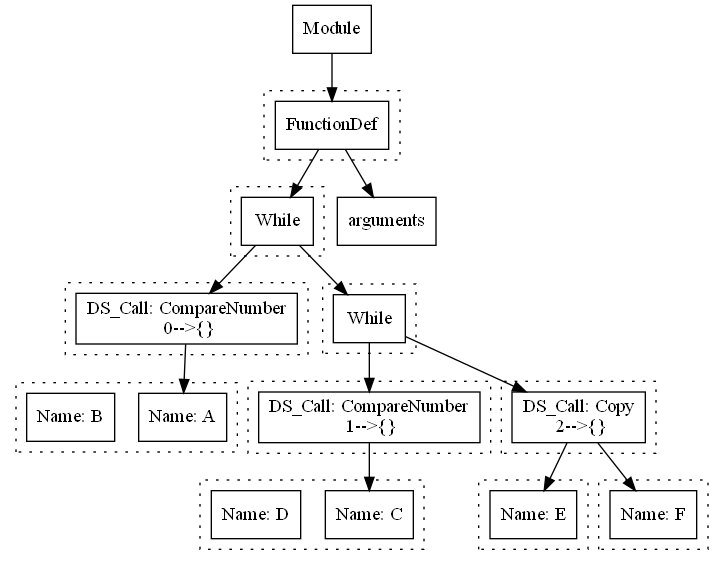

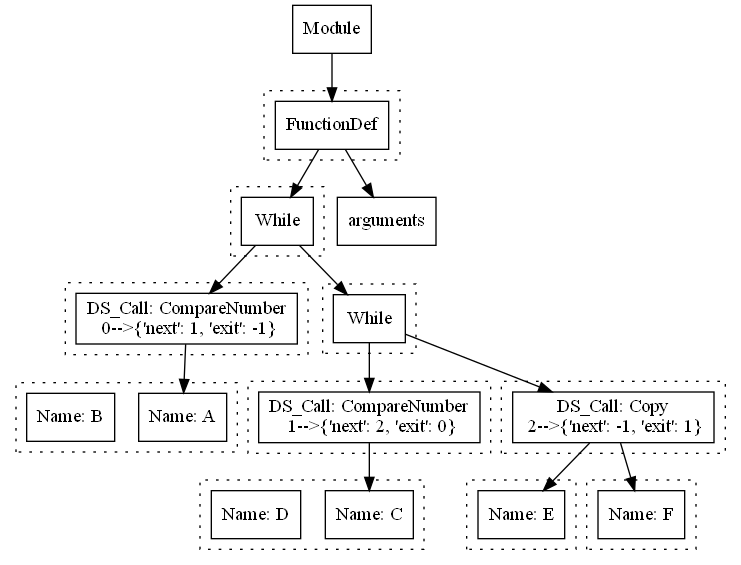

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='LoopRecipeIngredients', ctx=Load()),
                args=[Constant(value='metalplate', kind=None)],
            ),
        ),
    ],
)
DSCV0IAKl10aKfDP1CWBc01pAWMD1xveGW20HOmd2yRWc62Ojve301HC5Q2x6Goc1uWXQK1kL6HN1nkr8g22kZID057bW41IBxIG27JTdZ25rKi522kYYn31KypM28Eyyc1r1Zke1pzRit1z5hH51mcmnN006knS


In [35]:
def NestedWhile():
    while  CompareNumber(A,B):
        while  CompareNumber(C,D):
            E=F


astprint(ast.parse('LoopRecipeIngredients("metalplate")'))
print('')

tree = ast.parse(inspect.getsource(NestedWhile), type_comments=False)
tree = replace_binops_with_functions(tree)
tree = flatten_calls(tree)
tree = convert_to_ds_call(tree)
tree = label_frames_vars(tree)


astrender(tree)
flow_control(tree)

astrender(tree)

astprint(ast.parse('LoopRecipeIngredients("metalplate")'))

print(python_to_desynced(NestedWhile))